In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title Parameters
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"  # <-- provide path
START = "2025-01-01"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps
EMA_FAST_PERIOD = 50
EMA_SLOW_PERIOD = 200
SPLITS = (0.7, 0.15, 0.15)


In [3]:
import joblib
import numpy as np
import pandas as pd

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
import drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators as ind
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import enrich_q_labels_trend_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.visualisation import plot_enriched_actions_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns


In [4]:
# Load and check data
raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")


From 2025-01-01 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [5]:
# Add indicators
close = df['Close'].to_numpy(np.float64)
high = df['High'].to_numpy(np.float64)
low = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

df['EMA_fast_raw'] = ind.ema_numba(close, EMA_FAST_PERIOD)
df['EMA_slow_raw'] = ind.ema_numba(close, EMA_SLOW_PERIOD)
df['EMA_fast'] = ind.ema_numba_safe(close, EMA_FAST_PERIOD)
df['EMA_slow'] = ind.ema_numba_safe(close, EMA_SLOW_PERIOD)
df['SMA_14'] = ind.sma_numba(close, 14)
df['ADX_14'] = ind.adx_numba(high, low, close, 14)
df['ATR_14'] = ind.atr_numba(high, low, close, 14)
df['RSI_14'] = ind.rsi_numba(close, 14)
macd, macd_signal, macd_hist = ind.macd_numba(close, 12, 26, 9)
df['MACD'] = macd
df['MACD_signal'] = macd_signal
df['MACD_hist'] = macd_hist
stoch_k, stoch_d = ind.stoch_numba(high, low, close, 14, 3)
df['STOCH_K'] = stoch_k
df['STOCH_D'] = stoch_d
boll_mid, boll_up, boll_dn = ind.bollinger_numba(close, 20, 2.0)
df['BOLL_MID'] = boll_mid
df['BOLL_UP'] = boll_up
df['BOLL_DN'] = boll_dn
df['OBV'] = ind.obv_numba(close, volume)
df['CCI_20'] = ind.cci_numba(high, low, close, 20)
df['WILLR_14'] = ind.williams_r_numba(high, low, close, 14)
df['MFI_14'] = ind.mfi_numba(high, low, close, volume, 14)
df['ROC_12'] = ind.roc_numba(close, 12)
df['VWAP_20'] = ind.vwap_numba(high, low, close, volume, 20)
piv = ind.zigzag_pivots_highlow_numba(high, low, close, 0.05, -0.05, 3, 1)
df['Pivots'] = piv
df['Pivots_expanded'] = ind.expand_pivots(piv, 2)


In [6]:
# Добавляем сигнал референс стратегии
buy_sig  = (df['EMA_fast'] > df['EMA_slow']) & (df['Close'] > df['EMA_fast']) & (df['ADX_14'] > 20)
sell_sig = (df['EMA_fast'] < df['EMA_slow']) & (df['Close'] < df['EMA_fast']) & (df['ADX_14'] > 20)
df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)


In [7]:
# Q-labels
enriched = enrich_q_labels_trend_one_side(
    df,
    mode='tdlambda',
    H_max = 30,
    lam = 0.95,
    use_mae_penalty=False,
)
print(df[100:150].to_string())


                              timestamp     Open     High      Low    Close     Volume  EMA_fast_raw  EMA_slow_raw  EMA_fast  EMA_slow    SMA_14     ADX_14    ATR_14     RSI_14      MACD  MACD_signal  MACD_hist    STOCH_K    STOCH_D  BOLL_MID   BOLL_UP   BOLL_DN         OBV      CCI_20    WILLR_14     MFI_14    ROC_12   VWAP_20  Pivots  Pivots_expanded  Signal_Rule
datetime                                                                                                                                                                                                                                                                                                                                                                       
2025-01-01 01:40:00+00:00  1.735696e+12  0.31991  0.32007  0.31991  0.32006   142849.0      0.319425      0.318033  0.319425  0.318033  0.319561  19.772117  0.000290  59.982460  0.000181     0.000068   0.000113  85.443038  87.341772  0.319422  0.320362  0.318482  

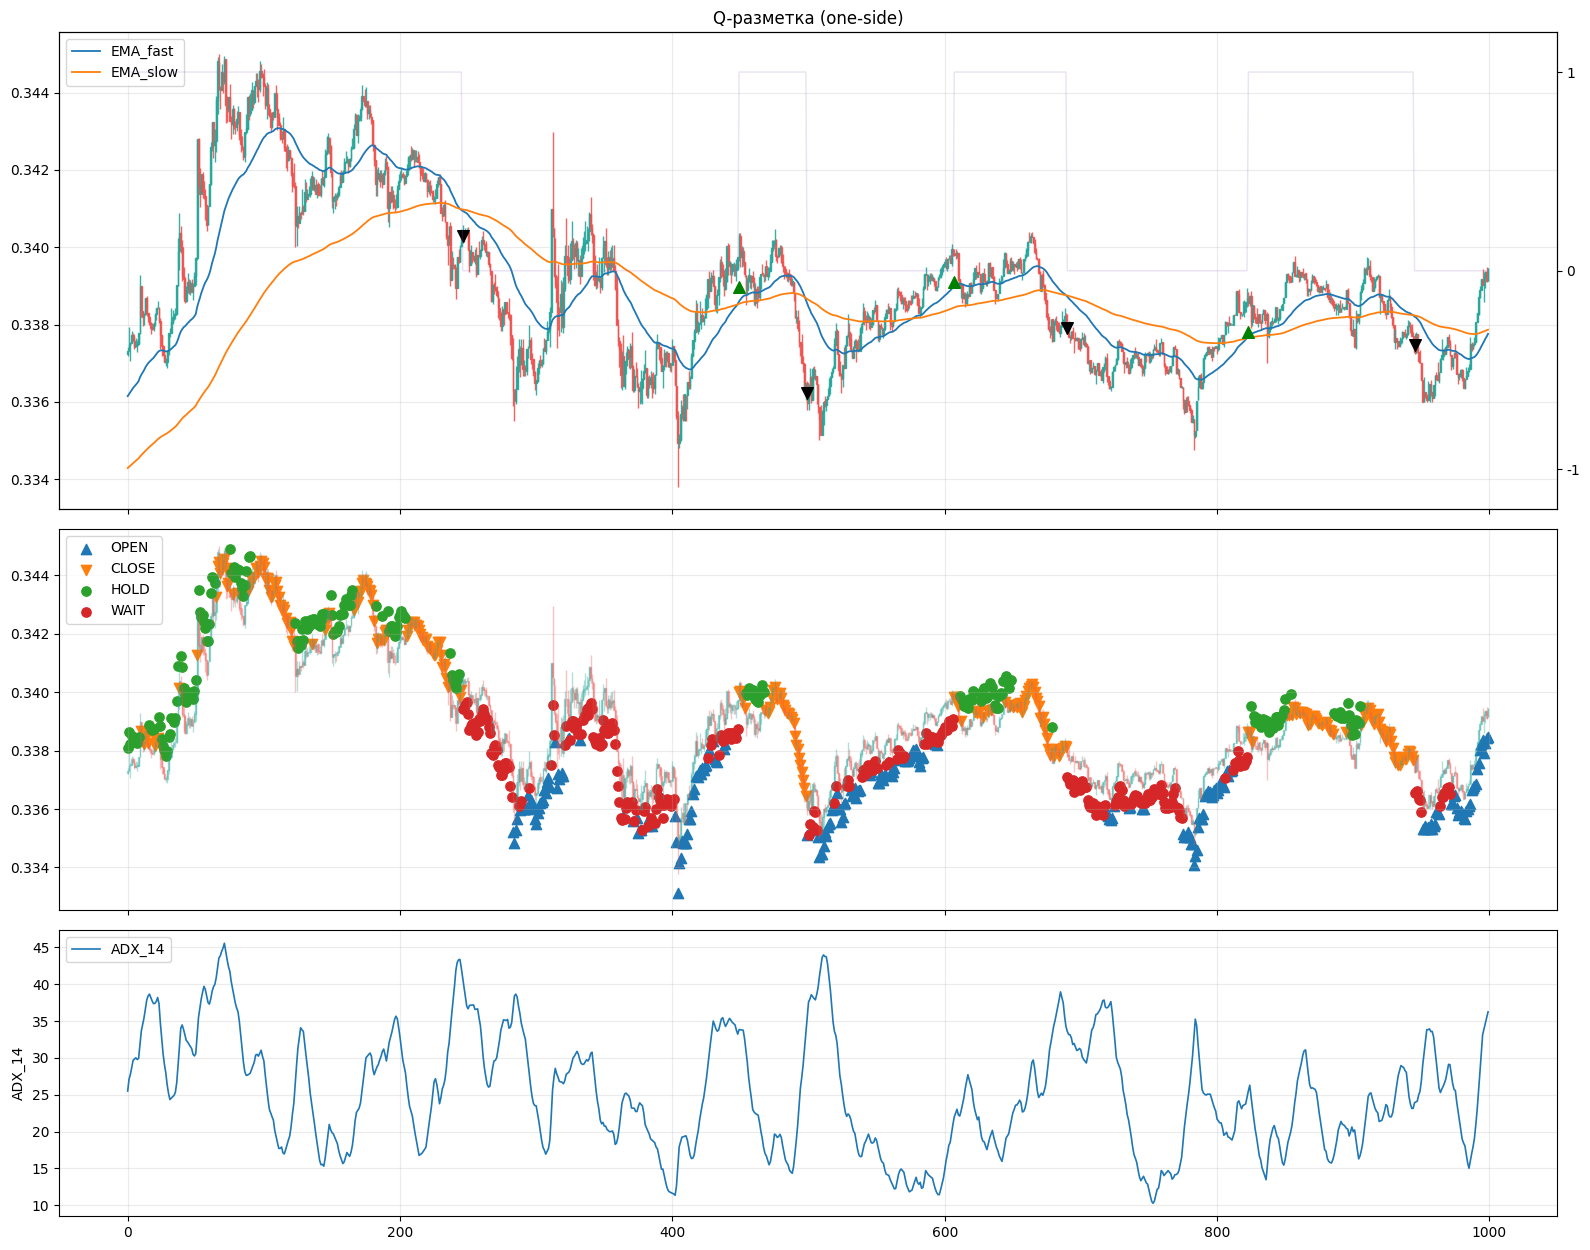

In [12]:
# Visualisation
plot_enriched_actions_one_side(
    enriched,
    start=2000,
    end=3000,
    indicators_price={
        'EMA_fast':enriched['EMA_fast'],
        'EMA_slow':enriched['EMA_slow'],
        },
    indicators_panels={
        'ADX_14':enriched['ADX_14'],
    }
)


In [13]:
# @title Нормализация и нарезка
builder = DatasetBuilderForYourColumns(
    seq_len=7, norm="minmax",
    labels_from="q",
    tau=1.0, r_mode="oracle",
    splits=SPLITS,
    batch_size=256,
    sw_mode="ClassBalance",
    drop_cols=["timestamp", "BarsToExit_Open", "BarsToExit_Hold", "Signal_Rule", "Pos"],
)
splits = builder.fit_transform(enriched)
train_ds, val_ds, test_ds = builder.as_tf_datasets(splits)

((xb, mb), (yb, Wb, Rb, SWb)) = next(iter(train_ds))
print("X:", xb.shape, "M:", mb.shape,
      "Y:", yb.shape, "W:", Wb.shape,
      "R:", Rb.shape, "SW:", SWb.shape)

print(yb[:10])



X: (256, 7, 29) M: (256, 4) Y: (256, 4) W: (256, 4) R: (256,) SW: (256,)
tf.Tensor(
[[0.         0.5002882  0.49971178 0.        ]
 [0.4993836  0.         0.         0.50061643]
 [0.         0.50026363 0.4997363  0.        ]
 [0.50028116 0.         0.         0.49971884]
 [0.         0.500352   0.49964797 0.        ]
 [0.5005406  0.         0.         0.49945936]
 [0.         0.49975476 0.5002453  0.        ]
 [0.5000556  0.         0.         0.4999444 ]
 [0.50062865 0.         0.         0.49937138]
 [0.5011088  0.         0.         0.49889117]], shape=(10, 4), dtype=float32)
